## Solving for eigenvalues and eigenvectors

We saw in the previous notebook how to set up a matrix by integrating between pairs of basis functions.  In this notebook we will solve for the eigenvalues and eigenvectors of the Hamiltonian for a square well, exploring what happens when we use a finite basis set, and introduce changes to the potential in the square well.

### Eigenbasis, adding potential

We will start by using the eigenbasis (since it's simple) and will add small changes to the potential.  This will give us some insight into the effect of perturbations (and will feed directly into our studies of perturbation theory).  So we'll first set up the bits and pieces of code we'll need, some taken from the previous notebook.

In [1]:
# Import libraries and set up in-line plotting.
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
# This is a new library - linear algebra includes solving for eigenvalues & eigenvectors of matrices
import numpy.linalg as la

# Define the eigenbasis - normalisation needed elsewhere
def square_well_eigenfunctions(n,width,norm,x):
    """The eigenbasis for a square well, running from 0 to a (width), sin(n pi x/a). 
    N.B. requires a normalisation factor, norm."""
    wavevector = np.pi*n/width
    return norm*np.sin(wavevector*x)

# We will also define the second derivative for kinetic energy (KE)
def second_derivative_square_well_eigenfunctions(n,width,norm,x):
    """The second derivative of the eigenbasis for a square well, running from 0 to a, sin(n pi x/a)"""
    wavevector = np.pi*n/width
    return -wavevector*wavevector*norm*np.sin(wavevector*x)

# Define the x-axis
square_well_width = 1.0
number_of_x_points = 101
x = np.linspace(0.0,square_well_width,number_of_x_points)
x_spacing = square_well_width/(number_of_x_points - 1)

# Integrate two functions over the width of the well
# NB this is a VERY simple integration routine: there are much better ways
def integrate_functions(function1,function2,dx):
    """Integrate two functions over defined x range with spacing dx"""
    # We use the NumPy dot function here instead of iterating over array elements
    integral = dx*np.dot(function1,function2)
    return integral

# These arrays will each hold an array of functions
basis_functions = []
second_derivative_basis_functions = []

number_of_basis_functions = 10
# Loop over first num_basis basis states, normalise and create an array
# NB the basis_array will start from 0
for n in range(1,number_of_basis_functions+1):
    # Calculate A = <phi_n|phi_n>
    integral = integrate_functions(square_well_eigenfunctions(n,square_well_width,1.0,x),square_well_eigenfunctions(n,square_well_width,1.0,x),x_spacing)
    # Use 1/sqrt{A} as normalisation constant
    normalisation = 1.0/np.sqrt(integral)
    basis_functions.append(square_well_eigenfunctions(n,square_well_width,normalisation,x))
    second_derivative_basis_functions.append(second_derivative_square_well_eigenfunctions(n,square_well_width,normalisation,x))


We have now set up all the mechanics that we need to create matrices for different Hamiltonians, except for one thing: the potential.  We have an implicit potential already in the infinite square well (we set $V=\infty$ when $x=0$ or $x=a$).  If we create a potential function, then we can change this and create different Hamiltonian matrices.  So we'll do this next.

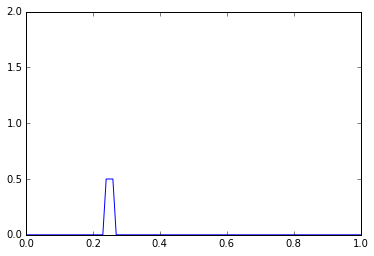

In [2]:
# Define constants - here I use atomic units
hbar = 1.0
hbar_squared = hbar*hbar
m_e = 1.0 # Mass of the electron
two_m_e = 2.0*m_e
# These are not needed but are easier
pi_squared = np.pi*np.pi
square_well_width_squared = square_well_width*square_well_width

# Define the potential in the square well
def square_well_perturbing_potential(x,perturbing_potential,potential_magnitude):
    """Potential for a particle in a square well, expecting two arrays: x, V(x), and potential magnitude"""
    # Zero the array
    perturbing_potential[:] = 0.0
    # Let's define a small bump in the well
    bump_position = x.size/4
    perturbing_potential[bump_position-1] = potential_magnitude
    perturbing_potential[bump_position] = potential_magnitude
    perturbing_potential[bump_position+1] = potential_magnitude
    # Plot to ensure that we know what we're getting
    pl.plot(x,perturbing_potential)
    pl.ylim((0,2.0))
    
# Declare space for this potential (Vbump) and call the routine
bump_potential = np.linspace(0.0,square_well_width,number_of_x_points)
square_well_perturbing_potential(x,bump_potential,0.5)

### Solving for the eigenvalues

Now that we have the potential, we need to build the matrix (remember that we have set $\hbar = m = 1$):

$H_{mn} = \langle \phi_m \vert -\frac{1}{2}\nabla^2 + \hat{V}\vert\phi_n\rangle$

By diagonalisation, we will find the eigenvalues.

It's worth noting that we act with $\hat{V}$ by multiplication in position representation:

$$\langle x \vert \hat{V} \vert \phi_m\rangle = V(x) \phi_m(x)$$

Then we make matrix elements by integration in position representation; as we've defined a grid on which to represent the system, we'll just sum over the values on the grid (though there are much more accurate ways to do numerical integration).

$$H_{ij} = \langle \phi_i \vert \hat{H} \vert \phi_j \rangle = \int dx \phi_i^\star(x) \hat{H} \phi_j(x)$$

We will print out the matrix of _just_ the potential first: $\langle \phi_m \vert \hat{V} \vert \phi_n\rangle$.  This will be useful when thinking about perturbation theory (the change in eigenvalues should be the same as the diagonal elements of the potential matrix, to first order in the potential).

In [3]:
# Declare space for the matrix elements - simplest with the identity function
H_matrix = np.eye(number_of_basis_functions)

# Define a function to act on a basis function with the potential
def add_potential_acting_on_state(H_on_phi,V,phi):
    """Add V(x)phi(x) onto an input array, H_on_phi"""
    for i in range(V.size):
        H_on_phi[i] = H_on_phi[i] + V[i] * phi[i]
        
print "Potential matrix elements:"
# Loop over basis functions phi_n (the bra in the matrix element)
# Calculate and output matrix elements of the potential

for n in range(number_of_basis_functions):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(number_of_basis_functions):
        # Act with H on phi_m and store in H_phi_m
        H_on_phi_m = np.zeros(number_of_x_points)
        add_potential_acting_on_state(H_on_phi_m, bump_potential, basis_functions[m])
        # Create matrix element by integrating
        H_mn = integrate_functions(basis_functions[n],H_on_phi_m,x_spacing)
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % H_mn,
    # This print puts in a new line when we have finished looping over m
    print

print
print "Full Hamiltonian"
# Loop over basis functions phi_n (the bra in the matrix element)
# Calculate and store the matrix elements for the full Hamiltonian
for n in range(number_of_basis_functions):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(number_of_basis_functions):
        # Act with H on phi_m and store in H_phi_m
        # First the kinetic energy
        H_on_phi_m = -(hbar_squared / two_m_e) * second_derivative_basis_functions[m] 
        # Now the potential
        add_potential_acting_on_state(H_on_phi_m, bump_potential, basis_functions[m])
        # Create matrix element by integrating
        H_mn = integrate_functions(basis_functions[n], H_on_phi_m, x_spacing)
        H_matrix[m,n] = H_mn
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % H_mn,
    # This print puts in a new line when we have finished looping over m
    print

Potential matrix elements:
   0.015    0.021    0.015   -0.000   -0.015   -0.021   -0.015    0.000    0.015    0.021
   0.021    0.030    0.021    0.000   -0.021   -0.030   -0.021   -0.000    0.021    0.029
   0.015    0.021    0.015    0.000   -0.015   -0.021   -0.015   -0.000    0.014    0.020
  -0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   -0.001   -0.000    0.000
  -0.015   -0.021   -0.015    0.000    0.015    0.021    0.014   -0.001   -0.015   -0.020
  -0.021   -0.030   -0.021   -0.000    0.021    0.029    0.021    0.000   -0.020   -0.029
  -0.015   -0.021   -0.015   -0.000    0.014    0.021    0.015    0.001   -0.014   -0.020
   0.000   -0.000   -0.000   -0.001   -0.001    0.000    0.001    0.001    0.001   -0.000
   0.015    0.021    0.014   -0.000   -0.015   -0.020   -0.014    0.001    0.015    0.020
   0.021    0.029    0.020    0.000   -0.020   -0.029   -0.020   -0.000    0.020    0.028

Full Hamiltonian
   4.950    0.021    0.015   -0.000   -0.015   -0.021  

Notice that two things have changed compared to the perfect square well: first, the diagonal elements are _slightly_ larger; second, there are now off-diagonal elements.  Does it surprise you that these alternate (i.e. only in odd row and columns) ? Think about the symmetries of the system, particularly of the wavefunctions.

What effect will this have on the eigenvalues and eigenvectors ? We'll diagonalise, print out the eigenvalues and plot the first few eigenvectors (as well as looking at their coefficients to get a rough idea of how much they've changed).

In [4]:
# Solve using linalg module of numpy (which we've imported as la above)
eigenvalues, eigenvectors = la.eigh(H_matrix)
# This call above does the entire solution for the eigenvalues and eigenvectors !
# Print results roughly, though apply precision of 4 to the printing
np.set_printoptions(precision=4)
print eigenvalues
print eigenvectors[0]
print eigenvectors[1]
print eigenvectors[2]

[   4.9498   19.7691   44.4282   78.9571  123.3851  177.6822  241.8203
  315.8286  399.734   493.5083]
[  1.0000e+00   1.4275e-03   3.7820e-04  -7.5022e-07   1.2595e-04
  -1.2134e-04   6.2036e-05   3.5439e-07   3.7203e-05   4.2008e-05]
[ -1.4279e-03   1.0000e+00   8.5641e-04   3.3707e-09   2.0269e-04
  -1.8751e-04   9.3925e-05  -1.4036e-09   5.4284e-05   6.1205e-05]
[ -3.7702e-04  -8.5703e-04   1.0000e+00   4.8328e-06   1.8593e-04
  -1.5688e-04   7.5635e-05  -1.2205e-06   4.0245e-05   4.5583e-05]


We can see that the eigenvalues look close to the perfect well values (we'll check them properly below).  The eigenvector coefficients show a single dominant value (corresponding to the unperturbed eigenvector), with very small contributions from other eigenvectors.  Now print the eigenvalues and calculate the change.

In [5]:
# Now print out eigenvalues and the eigenvalues of the perfect square well, and the difference
print " Changed Original  Difference"
for i in range(number_of_basis_functions):
    n = i+1
    print "%8.3f %8.3f %8.3f" % (eigenvalues[i],n*n*np.pi*np.pi/2.0,eigenvalues[i] - n*n*np.pi*np.pi/2.0)

 Changed Original  Difference
   4.950    4.935    0.015
  19.769   19.739    0.030
  44.428   44.413    0.015
  78.957   78.957    0.000
 123.385  123.370    0.015
 177.682  177.653    0.029
 241.820  241.805    0.015
 315.829  315.827    0.001
 399.734  399.719    0.015
 493.508  493.480    0.028


Compare the differences in eigenvalues due to the small potential we've added to the diagonal terms of the potential matrix.  How close is the agreement ? You might like to change the magnitude of the potential (higher up - it's passed as an argument to the potential function) and see how this agreement changes.

Now we'll plot the eigenvectors (after building them) and look at the change with respect to the eigenvectors of the original system.  Remember that any function in this space can be written as:

$$\vert\psi\rangle = \sum_i c_i \vert \phi_i \rangle$$

We'll use this to build the eigenfunctions of the perturbed system.  In this case, $c_i$ are the coefficients in the eigenvector of the matrix, and $\vert\phi_i\rangle$ are the basis functions.

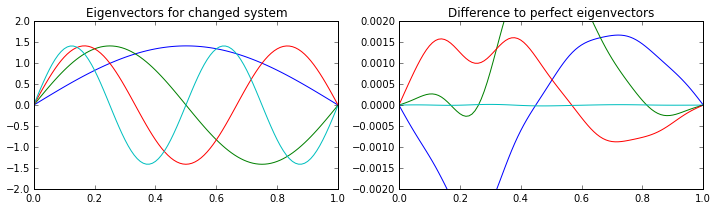

In [6]:
# Define a figure to take two plots
fig = pl.figure(figsize=[12,3])
# Add subplots: number in y, x, index number
ax = fig.add_subplot(121,autoscale_on=False,xlim=(0,1),ylim=(-2,2))
ax.set_title("Eigenvectors for changed system")
ax2 = fig.add_subplot(122,autoscale_on=False,xlim=(0,1),ylim=(-0.002,0.002))
ax2.set_title("Difference to perfect eigenvectors")
for m in range(4): # Plot the first four states
    psi = np.zeros(number_of_x_points)
    for i in range(number_of_basis_functions):
        psi = psi+eigenvectors[i,m]*basis_functions[i]
    if eigenvectors[m,m] < 0:  # This is just to ensure that psi and the basis function have the same phase
        psi = -psi
    ax.plot(x,psi)
    # Now subtract the unperturbed eigenvector to see the change from the perturbation
    psi = psi - basis_functions[m]
    ax2.plot(x,psi)


Notice how the eigenvectors for this changed system are *very* close to the original system.  This is a perfect example of a good system to study with perturbation theory.  The changes in the eigenvectors can be related to matrix elements of the potential and the eigenvalues of the unperturbed system, but we won't do this just yet.

In the next notebook, we will explore a more complex perturbation (a truncated quantum harmonic oscillator, or QHO) and the effects of varying the magnitude of the perturbation.  As well as improving your understanding of matrix mechanics, this should give a useful insight into the limitations of perturbation theory and finite basis sets.